# Car dataset classification training

I've try both tensorflow.keras and pytorch for practicing.

I tried different models and got some predictions. I let the predictions vote for the finally predicted label.  
(More details are in voted_pred.py)

Reference:
- https://github.com/h2chen/tensorflow-render
- https://www.kaggle.com/deepbear/pytorch-car-classifier-90-accuracy
- https://towardsdatascience.com/deep-cars-transfer-learning-with-pytorch-3e7541212e85

# Preproccessing

### Mount google drive (Optional)

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import

In [8]:
# import packages
import numpy as np
from PIL import Image
import csv
import tensorflow as tf
from os import walk
import os
from datetime import datetime
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import statistics
from sklearn.model_selection import train_test_split

################## tensorflow #########################

from tensorflow import keras
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Pretrained models

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_rn50

from tensorflow.keras.applications.resnet import ResNet152
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_input_rn152
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_input_rn101v2

from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_input_dn201

from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_input_nnl

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_input_irv2

##################### pytorch ##########################

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import time
from IPython.display import display

# Configs

In [30]:
# Original training data path (All 11185 training images are in this directory.)
ORIGINAL_TRAINING_DATA_DIR = 'Custome Path'
TRAIN_LABEL_PATH = 'Custome Path'
CLASSIFY_DEST_DIR = 'Custome Path'
TO_BE_RESIZED_TESTING_DIR = 'Custome Path'
TRAIN_VALID_TEST_SPLIT_DIR = 'Custome Path'
# color setting and testing data resized setting
RESIZED_MODE = 'rgb'  # 'rgb' or 'grayscale'
# RESIZED_RESULT_DIR = TRAIN_VALID_TEST_SPLIT_DIR + '/test/test'
# predict setting
MODEL_TRAINED_PATH = 'Custome Path/???.h5'
TEST_DIR = 'Custome Path'
PRED_RESULT_PATH = TRAIN_VALID_TEST_SPLIT_DIR

# Preparing Functions (Must Run)
The functions here must run before training.

### Construct dicts about id <=> label & labelNum <=> labelName
Read information from training data label.  
Make dicts about: (x is id; y is label here.)
- x to y
- y to x
- x_data
- y_data

Since the name of label contains illegal character for file name (slash). I solve it by giving every label a number. Therefore, we also make dicts to record the relationship of label name and its corresponding number.
- yNum to yName
- yName to yNum

In [ ]:
# Make dicts about id <=> label
class Labeldict:
    def __init__(self):
        # initialize variables
        self.train_x_y_dict = {}  # str to str
        self.train_y_x_dict = {}  # str to a list of str
        self.x_data = []  # list of str
        self.y_data = []  # list of str
        self.yName_to_yNum_dict = {}  # dict: str to str (The 'Num' and 'Name' here are both in str.)
        self.yNum_to_yName_dict = {}  # dict: str to str(The 'Num' and 'Name' here are both in str.)
        self.__have_read_train_label_file = False
        # initialization function
        self.read_train_label_file(skip_first_line=True)
        # P.S.
        # We need dict of yName and yNum because label name may contain invalid path chars.
        # That is, you cannot let some labels be directories' names.

    # Read training data label file.
    # Make:
    #  - train_x_y_dict
    #  - train_y_x_dict
    #  - x_data list
    #  - y_data list
    #  - yName_to_yNum_dict (The 'Num' and 'Name' here are both in str.)
    #  - yNum_to_yName_dict (The 'Num' and 'Name' here are both in str.)
    def read_train_label_file(self, skip_first_line=False):
        # Read file and make train_x_y_dict, x_data list, and y_data list.
        train_x_y_dict = {}
        x_data = []
        y_data = []
        have_seen_first = False if skip_first_line else True
        with open(TRAIN_LABEL_PATH) as csvFile:
            reader = csv.reader(csvFile)
            for row in reader:
                if have_seen_first:
                    train_x_y_dict[row[0]] = row[1]
                    x_data.append(row[0])
                    y_data.append(row[1])
                else:
                    have_seen_first = True
        self.train_x_y_dict = train_x_y_dict
        self.x_data = x_data
        self.y_data = y_data
        print('=== Read training label file successfully! ===')
        print('Have read {} x_data.'.format(len(x_data)))
        print('Have read {} y_data(label).'.format(len(y_data)))
        print('Have made a train_x_y_dict with length {}.'.format(len(train_x_y_dict)))
        # Collect unique labels
        unique_y = np.unique(np.array(y_data), return_counts=False)
        # Make train_y_x_dict
        train_y_x_dict = {}
        for label in unique_y:
            train_y_x_dict[str(label)] = []  # initialization
        for imgId in train_x_y_dict:
            train_y_x_dict[train_x_y_dict[imgId]].append(imgId)
        self.train_y_x_dict = train_y_x_dict
        print('Have made a train_y_x_dict with length {}.'.format(len(train_y_x_dict)))
        # Count number of values in train_y_x_dict totally
        total_sum = 0
        for y in train_y_x_dict:
            total_sum += len(train_y_x_dict[y])
        print('Total values in train_y_x_dict: {}'.format(total_sum))
        # Make yName_to_yNum_dict and yNum_to_yName_dict (The 'Num' and 'Name' here are both in str.)
        yname_to_ynum_dict = {}
        ynum_to_yname_dict = {}
        for i, y in enumerate(unique_y):
            y = str(y)
            yname_to_ynum_dict[y] = i
            ynum_to_yname_dict[i] = y
        self.yName_to_yNum_dict = yname_to_ynum_dict
        self.yNum_to_yName_dict = ynum_to_yname_dict
        print('Have made yName_to_yNum_dict with length: {}'.format(len(yname_to_ynum_dict)))
        print('Have made yNum_to_yName_dict with length: {}'.format(len(ynum_to_yname_dict)))
        # Finish reading
        self.__have_read_train_label_file = True

    def write_ynum_to_yname_csvfile(self, filename):
        # Must have read training data label file before.
        if not self.__have_read_train_label_file:
            print('ERROR: Have not successfully read training label file before doing this!')
            return
        with open(filename, 'w+') as csvFile:
            writer = csv.writer(csvFile)
            for labelNum in self.yNum_to_yName_dict:
                writer.writerow([labelNum, self.yNum_to_yName_dict[labelNum]])

In [ ]:
labeldict = Labeldict()

=== Read training label file successfully! ===
Have read 11185 x_data.
Have read 11185 y_data(label).
Have made a train_x_y_dict with length 11185.
Have made a train_y_x_dict with length 196.
Total values in train_y_x_dict: 11185
Have made yName_to_yNum_dict with length: 196
Have made yNum_to_yName_dict with length: 196


# Extra functions (Optional running)

### Classify training data and save them in their class's directories

In [ ]:
# Make all training data stored in their classes' directories.
# Notes: Plaese ensure labeldict has been constructed before running this block.

def classify_training_data_save(labeldict_obj, original_training_data_dir, classify_dest_dir):
    # Get filenames
    filenames = []
    for root, dirs, files in walk(original_training_data_dir):
        for file in files:
            filenames.append(file)
    print('Number of files: {}'.format(len(filenames)))
    print('Let\'s see some filenames: {}, {}, ......'.format(filenames[0], filenames[1]))

    #
    print('Start to save images......')
    sum_saved = 0
    for label in labeldict.train_y_x_dict:
        labelNum = str(labeldict.yName_to_yNum_dict[label])
        for file in labeldict.train_y_x_dict[label]:
            img = Image.open(original_training_data_dir + '/' + file + '.jpg')
            if not os.path.exists(classify_dest_dir + '/' + labelNum):
                os.mkdir(classify_dest_dir + '/' + labelNum)
            img.save(classify_dest_dir + '/' + labelNum + '/' + file + '.jpg')
            sum_saved += 1
            print('Have saved {} images.'.format(sum_saved))
    print('Done! Totally saved {} images.'.format(sum_saved))


if input('Type true if you are sure to do this:') is 'true':
    classify_training_data_save(labeldict, ORIGINAL_TRAINING_DATA_DIR, CLASSIFY_DEST_DIR)
else:
    print('Abort')

# (A) Keras

### Parameter setting

In [ ]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
BATCH_SIZE = 32
LR = 1e-4 * 1
NUM_EPOCH = 100

### Test GPU (Optional)

In [ ]:
# Test GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load model  (Optional)

In [ ]:
# Load Model
model_path = '???'
model = models.load_model(model_path)

### Make Datalist in dataframe (★Must run before image generator)

In [ ]:
# Make 
def DataList(data_path):
    img_list, data_label, data_types = [], [], []
    class_path = ""
    for root, dirs, files in os.walk(data_path):
        if root.split("/")[-1] != "model-logs":
            files.sort()
            for file in files:
                if file.find("checkpoint") == -1:
                    if file[-3:] == "csv":
                        class_path = os.path.join(root, file)
                    else:
                        img_list.append(os.path.join(root, file))
                        label = root.split("/")[-1]
                        types = root.split("/")[-2]
                        data_label.append(label)
                        data_types.append(types)

    data_list = pd.DataFrame({"img_path": img_list, "label_name": data_label, "types": data_types})
    data_list.sort_values(by=['label_name'])

    data_list["label"] = data_list["label_name"]

    train_list = data_list[data_list["types"] == "train"][["img_path", "label_name", "label"]].copy()
    valid_list = data_list[data_list["types"] == "valid"][["img_path", "label_name", "label"]].copy()

    return train_list, valid_list


if os.path.exists(TRAIN_VALID_TEST_SPLIT_DIR):
    train_list, valid_list = DataList(TRAIN_VALID_TEST_SPLIT_DIR)
else:
    print('The directory does not exists.')

num_classes = train_list["label"].unique().shape[0]
print('Num of classes:', num_classes)

Num of classes: 196


### Image Generators

Found 10066 validated image filenames belonging to 196 classes.
Found 1119 validated image filenames belonging to 196 classes.
Found 5000 images belonging to 2 classes.
{'0': 0, '1': 1, '10': 2, '100': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '107': 10, '108': 11, '109': 12, '11': 13, '110': 14, '111': 15, '112': 16, '113': 17, '114': 18, '115': 19, '116': 20, '117': 21, '118': 22, '119': 23, '12': 24, '120': 25, '121': 26, '122': 27, '123': 28, '124': 29, '125': 30, '126': 31, '127': 32, '128': 33, '129': 34, '13': 35, '130': 36, '131': 37, '132': 38, '133': 39, '134': 40, '135': 41, '136': 42, '137': 43, '138': 44, '139': 45, '14': 46, '140': 47, '141': 48, '142': 49, '143': 50, '144': 51, '145': 52, '146': 53, '147': 54, '148': 55, '149': 56, '15': 57, '150': 58, '151': 59, '152': 60, '153': 61, '154': 62, '155': 63, '156': 64, '157': 65, '158': 66, '159': 67, '16': 68, '160': 69, '161': 70, '162': 71, '163': 72, '164': 73, '165': 74, '166': 75, '167': 76, '168

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


146
Jeep Liberty SUV 2012


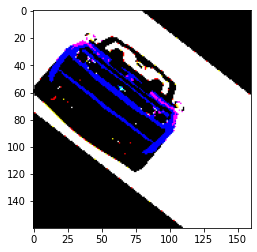

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


137
Hyundai Tucson SUV 2012


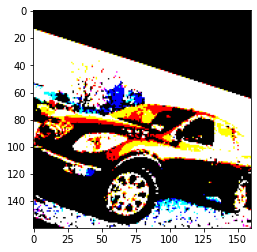

177
Scion xD Hatchback 2012


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


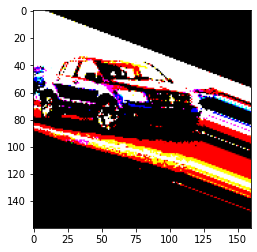

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


102
Ferrari California Convertible 2012


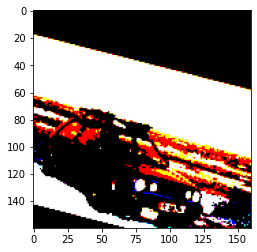

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12
Audi 100 Wagon 1994


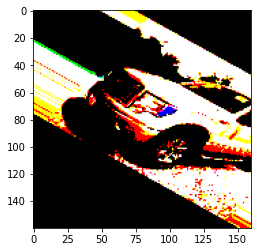

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


186
Toyota Camry Sedan 2012


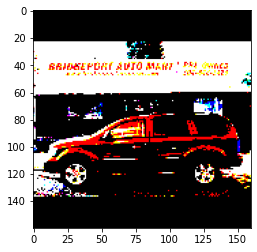

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


179
Spyker C8 Coupe 2009


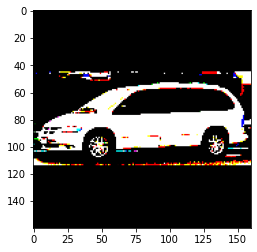

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17
Audi S4 Sedan 2012


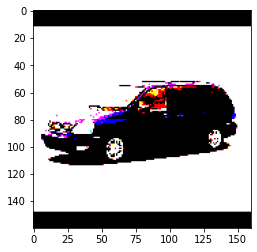

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


90
Dodge Durango SUV 2007


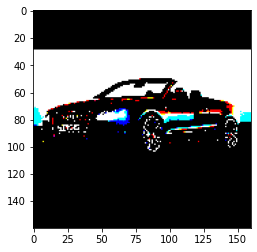

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80
Chrysler Town and Country Minivan 2012


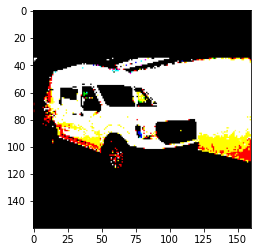

In [ ]:
# Data generators of training, validation and testing.
# It'll print 5 images from trainin images and 5 from validation images.

train_datagen = ImageDataGenerator(
    rotation_range=40,
    horizontal_flip=True,
    # vertical_flip=True,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    # rescale=1./255,
    preprocessing_function=preprocess_input_rn50
)
valid_datagen = ImageDataGenerator(
    #  rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True,
    # zoom_range=0.1,
    # rescale=1./255,
    preprocessing_function=preprocess_input_rn50
)
test_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=preprocess_input_rn50
)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_list,
    directory="",
    x_col="img_path",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # tuple:(heigth,width)
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_list,
    directory="",
    x_col="img_path",
    y_col="label",
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # tuple:(heigth,width)
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    directory=TRAIN_VALID_TEST_SPLIT_DIR + '/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False
)

# Print images for checking.
generator_indices = valid_generator.class_indices
print(generator_indices)

x, y = train_generator.next()
for i in range(0, 5):
    image = x[i]
    label = y[i]
    # print(label)
    labelNum = label.argmax(axis=0)
    print(labelNum)
    print(labeldict.yNum_to_yName_dict[(labelNum)])
    plt.imshow(image)
    plt.show()

x, y = valid_generator.next()
for i in range(0, 5):
    image = x[i]
    label = y[i]
    # print(label)
    labelNum = label.argmax(axis=0)
    print(labelNum)
    print(labeldict.yNum_to_yName_dict[(labelNum)])
    plt.imshow(image)
    plt.show()

### Model

In [ ]:
# Choose pretrained model
###########################
pre_model = ResNet50(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# pre_model = ResNet152(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# pre_model = ResNet101V2(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# pre_model = DenseNet201(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# pre_model = NASNetLarge(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)
# pre_model = InceptionResNetV2(weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False)

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
# Decide if pretrain model trainable
#########################################
# pre_model.trainable = False
pre_model.trainable = True
# for each_layer in pre_model.layers[:-25]:
    # each_layer.trainable = True

In [ ]:
# Add layers and complete the neural network
############################################################
x = layers.GlobalAveragePooling2D()(pre_model.output)
# x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(1024, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
# outputs = layers.Dense(num_classes, activation="softmax")(pre_model.output)
############################################################
model_keras = keras.models.Model(inputs=pre_model.inputs, outputs=outputs)

In [ ]:
# Choose optimizer
######################################################################
optimizer = keras.optimizers.Adam(LR)
# optimizer = keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
model_keras.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Training

In [ ]:
# Callback Setting
model_dir = os.path.join(TRAIN_VALID_TEST_SPLIT_DIR, 'model-logs')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

now = datetime.now()
modelfiles = model_dir + '/temp-{}-w{}h{}-rand{}-model.h5'.format(now.strftime("%Y-%m%d-%H:%M:%S"), IMG_WIDTH,
                                                                  IMG_HEIGHT, random.randint(0, 999))
model_mckp = callbacks.ModelCheckpoint(modelfiles,
                                       monitor='val_accuracy',
                                       save_best_only=False)

earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                    patience=3,
                                    verbose=1)

callbacks_list = [model_mckp, earlystop]

In [ ]:
# Calculate steps
def num_steps_per_epoch(data_generator, BATCH_SIZE):
    if data_generator.n % BATCH_SIZE == 0:
        return data_generator.n // BATCH_SIZE
    else:
        return data_generator.n // BATCH_SIZE + 1


train_steps = num_steps_per_epoch(train_generator, BATCH_SIZE)
valid_steps = num_steps_per_epoch(valid_generator, BATCH_SIZE)

In [ ]:
# See layers of the model
model_keras.summary()

In [ ]:
# Train
history = model_keras.fit_generator(train_generator,
                                    steps_per_epoch=train_steps,
                                    epochs=NUM_EPOCH,
                                    validation_data=valid_generator,
                                    validation_steps=valid_steps,
                                    callbacks=callbacks_list)

# Save model after training
now = datetime.now()
model_path = model_dir + '/{}-w{}h{}-{}-last-model.h5'.format(now.strftime("%Y-%m%d-%H:%M:%S"), IMG_WIDTH, IMG_HEIGHT,
                                                              history.history['val_accuracy'][-1])
model_keras.save(model_path)

In [ ]:
# Manually save model
model_keras = model_dir + '/{}-w{}h{}-{}-last-model.h5'.format(now.strftime("%Y-%m%d-%H:%M:%S"), IMG_WIDTH, IMG_HEIGHT,
                                                               history.history['val_accuracy'][-1])
model_keras.save(model_path)

### Predict testing data

In [ ]:
# Version 1: Predict images one by one

filenames = []
for root, dirs, files in walk(TEST_DIR):
    for file in files:
        filenames.append(file)
filenames.sort()

now = datetime.now()

with open(PRED_RESULT_PATH + '/' + now.strftime("%H:%M:%S") + '_pred.csv', 'w+') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(['id', 'label'])
    havePredicted = 0
    for file in filenames:
        img = Image.open(TEST_DIR + '/' + file)
        img_arr = np.array(img)
        img_tensor = np.expand_dims(img_arr, axis=0)
        if img_tensor.shape != (1, IMG_HEIGHT, IMG_WIDTH, 3):
            print(file)
            # print(img_tensor.shape)
            # print(img_tensor)
            img_tensor = np.expand_dims(np.array(img.convert('RGB')), axis=0)
            # print(new_img_tensor.shape)
            # print(new_img_tensor)
            # break
        img_tensor = preprocess_input(img_tensor)
        print('predicting: {}'.format(file))
        pred = model_keras.predict(img_tensor)
        havePredicted += 1
        pred_num = pred.argmax(axis=1)[0]
        img_id = file.split('.')[0]
        labelName = labeldict.yNum_to_yName_dict[(pred_num)]
        print('Have predicted {} items, pred label: {} => {}'.format(havePredicted, pred_num, labelName))
        writer.writerow([img_id, labelName])

5000/5000 [==============================] - 100s 20ms/step
pred_results.shape: (5000, 196)


In [ ]:
# Predict Method 2: using Data Generator

pred_results = model_keras.predict(test_generator, verbose=1)
print('pred_results.shape: {}'.format(pred_results.shape))

now = datetime.now()

with open(PRED_RESULT_PATH + '/' + now.strftime("%H:%M:%S") + '_pred.csv', 'w+') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(['id', 'label'])
    havePredicted = 0
    print(len(test_generator))
    print(pred_results.shape)
    for i in range(len(test_generator)):
        pred_num = pred_results[i].argmax(axis=0)
        img_id = str(str(test_generator.filenames[i]).split('/')[-1]).split('.')[0]
        print(img_id)
        real_pred_num = ''
        for key in generator_indices:
            if generator_indices[key] == pred_num:
                real_pred_num = key
                break
        labelName = labeldict.yNum_to_yName_dict[int(real_pred_num)]
        print('Have predicted {} items, pred label: {} => {}'.format(i + 1, pred_num, labelName))
        writer.writerow([img_id, labelName])
print('Done')


串流輸出內容已截斷至最後 5000 行。
008182
Have predicted 2502 items, pred label: 6 => Ferrari FF Coupe 2012
008183
Have predicted 2503 items, pred label: 6 => Ferrari FF Coupe 2012
008191
Have predicted 2504 items, pred label: 6 => Ferrari FF Coupe 2012
008197
Have predicted 2505 items, pred label: 6 => Ferrari FF Coupe 2012
008203
Have predicted 2506 items, pred label: 6 => Ferrari FF Coupe 2012
008207
Have predicted 2507 items, pred label: 6 => Ferrari FF Coupe 2012
008210
Have predicted 2508 items, pred label: 6 => Ferrari FF Coupe 2012
008212
Have predicted 2509 items, pred label: 6 => Ferrari FF Coupe 2012
008214
Have predicted 2510 items, pred label: 6 => Ferrari FF Coupe 2012
008219
Have predicted 2511 items, pred label: 6 => Ferrari FF Coupe 2012
008221
Have predicted 2512 items, pred label: 6 => Ferrari FF Coupe 2012
008224
Have predicted 2513 items, pred label: 180 => Dodge Challenger SRT8 2011
008226
Have predicted 2514 items, pred label: 6 => Ferrari FF Coupe 2012
008227
Have predicted 2

# (B) Pytorch

### Parameter Setting

In [ ]:
BATCH_SIZE_B = 32
NUM_EPOCHS = 10

### Check cuda

In [ ]:
# Check if cuda is available
print(torch.cuda.is_available())

### Data transformations

In [ ]:
# Do data transformations and data loaders
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
valid_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset_train = torchvision.datasets.ImageFolder(root=TRAIN_VALID_TEST_SPLIT_DIR + "train", transform=train_tfms)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH_SIZE_B, shuffle=True, num_workers=2)

dataset_valid = torchvision.datasets.ImageFolder(root=TRAIN_VALID_TEST_SPLIT_DIR + "valid", transform=valid_tfms)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH_SIZE_B, shuffle=False, num_workers=2)

### Function of training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    
    # set the model to train mode initially
    model.train()

    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

### Function of evaluating

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(valid_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

### Modeling

In [ ]:
model_B = models.resnet34(pretrained=True)
num_features = model_B.fc.in_features

model_B.fc = nn.Linear(num_features, 196)
model_B = model_B.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_B.parameters(), lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold=0.9)

### Train

In [ ]:
model_B, training_losses, training_accs, test_accs = train_model(model_B, criterion, optimizer, lrscheduler,
                                                                 n_epochs=NUM_EPOCHS)


### Save model

In [ ]:
model_save_name = "???.pt"
path = F"/content/drive/My Drive/{model_save_name}"
torch.save(model_B.state_dict(), path)

### Load model

In [ ]:
model_B_loaded_path = "???.pt"
model_B_loaded = model_B
model_B_loaded.load_state_dict(torch.load(model_B_loaded_path))
model_B_loaded.to(device)
model_B = model_B_loaded

### Predict and save as a csv file

In [ ]:
from os import walk
import os
from datetime import datetime

PRED_RESULT_PATH = '/content/drive/My Drive/CV/hw1/pytorch_90'
TEST_DIR = '/content/drive/My Drive/CV/hw1/Data/testing_data/testing_data'
# switch the model to evaluation mode to make dropout and batch norm work in eval mode
model_B.eval()
# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



filenames = []
for root, dirs, files in walk(TEST_DIR):
    for file in files:
        filenames.append(file)
filenames.sort()

now = datetime.now()

with open(PRED_RESULT_PATH + '/'+ now.strftime("%H:%M:%S") + '_pytorch90_pred.csv', 'w+') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(['id', 'label'])
    havePredicted = 0
    for file in filenames:     
        if file.split('.')[-1]!='jpg':
          continue
        img_path = os.path.join(TEST_DIR,file)
        image = Image.open(img_path)
        image_arr = np.array(image)
        if image_arr.shape != (400,400, 3):
            print(file)
            image_arr = np.array(image.convert('RGB'))
        print(image_arr.shape)
        image = Image.fromarray(image_arr)
        image = loader(image).float()
        image = torch.autograd.Variable(image, requires_grad=True)
        image = image.unsqueeze(0)
        image = image.cuda()
        output = model_B(image)
        conf, predicted = torch.max(output.data, 1) 
        label_name = labeldict.yNum_to_yName_dict[int(classes[predicted.item()])]    

        havePredicted += 1
        
        img_id = file.split('.')[0]
        
        print('Have predicted {} items, pred label: {} => {}'.format(havePredicted,classes[predicted.item()],label_name))
        writer.writerow([img_id,label_name])